In [44]:
from sklearn.datasets import load_digits

In [45]:
digits = load_digits()
X = digits.images
y = digits.target

In [46]:
# see the shape of the images
print("Images shape:",X.shape)
print("labels shape:",y.shape)

Images shape: (1797, 8, 8)
labels shape: (1797,)


8×8 grayscale images images hai

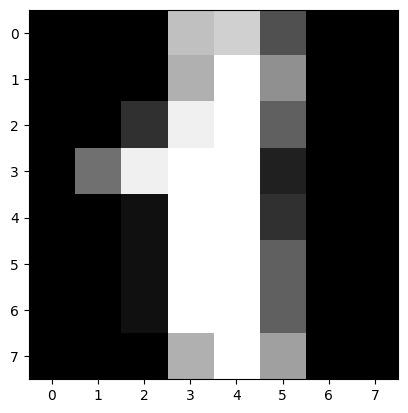

In [47]:
# see the images pictures
import matplotlib.pyplot as plt
plt.imshow(X[1], cmap='gray')
plt.show()

In [48]:
# input shape cnn [Batch, Channel, Height, Width]
X.shape # see the channel dimention are missing


(1797, 8, 8)

In [49]:
import numpy as np
X = X[:, np.newaxis, :, :]   # shape ab (1797, 1, 8, 8)
print("After channel add:", X.shape)

After channel add: (1797, 1, 8, 8)


In [50]:
# data set has pixal 0 to 16
# but we 0 to 1
X = X/16
print("Pixel range:", X.min(), "to", X.max())

Pixel range: 0.0 to 1.0


In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [52]:
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape :", X_test.shape, y_test.shape)

Train shape: (1437, 1, 8, 8) (1437,)
Test shape : (360, 1, 8, 8) (360,)


In [53]:
# convert the torch tensor
import torch
X_train_t = torch.tensor(X_train,dtype=torch.float32)
y_train_t = torch.tensor(y_train,dtype=torch.long)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

In [54]:
# dataloader
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

In [55]:
# dataloader
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [56]:
# chacke the dataste
xb,yb = next(iter(train_loader))
print("X batch shape:", xb.shape)
print("Y batch shape:", yb.shape)

X batch shape: torch.Size([32, 1, 8, 8])
Y batch shape: torch.Size([32])


In [57]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # convolutional part
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # reduce size 8x8 -> 4x4

        # fully connected part
        self.fc1 = nn.Linear(16 * 4 * 4, 64)  # flatten -> 64 neurons
        self.fc2 = nn.Linear(64, 10)          # output 10 classes (0–9)

    def forward(self, x):
        # convolution block
        x = self.conv1(x)        # conv
        x = torch.relu(x)        # activation
        x = self.pool(x)         # downsample (8x8 → 4x4)

        # flatten
        x = x.view(-1, 16 * 4 * 4)

        # fully connected block
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [58]:
# lets see themodel
model  = SimpleCNN()
xb,yb = next(iter(train_loader))
out = model(xb)
print(xb.shape)
print(out.shape)


torch.Size([32, 1, 8, 8])
torch.Size([32, 10])


In [59]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [60]:
epochs = 10
for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  for images, labels in train_loader:

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs,labels)

    # backward loss
    loss.backward()
    optimizer.step()
    running_loss +=loss.item()

  avg_loss = running_loss / len(train_loader)
  print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 2.1763
Epoch [2/10], Loss: 1.6292
Epoch [3/10], Loss: 0.9183
Epoch [4/10], Loss: 0.5433
Epoch [5/10], Loss: 0.3847
Epoch [6/10], Loss: 0.2919
Epoch [7/10], Loss: 0.2422
Epoch [8/10], Loss: 0.2181
Epoch [9/10], Loss: 0.1858
Epoch [10/10], Loss: 0.1695


In [61]:
# testing ke liye
model.eval()
correct, total = 0, 0
with torch.no_grad():
  for images, labels in test_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 93.89%


In [62]:
# lets incresses performance
import torch.nn as nn

class ImprovedCNN(nn.Module):
  def __init__(self):
    super(ImprovedCNN, self).__init__()
    self.conv1 = nn.Conv2d(1,32,kernel_size=3,padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(2,2)

    self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.bn2 = nn.BatchNorm2d(64)

    #fully conneted part
    self.fc1 = nn.Linear(64*2*2,128)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(128,10)

  def forward(self, x):
    x = self.pool(torch.relu(self.bn1(self.conv1(x))))
    x = self.pool(torch.relu(self.bn2(self.conv2(x))))
    x = x.view(x.size(0), -1)
    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [63]:
model_1 = ImprovedCNN()
in_idx,out_idx = next(iter(train_loader))
out = model_1(in_idx)
print(in_idx.shape)
print(out.shape)

torch.Size([32, 1, 8, 8])
torch.Size([32, 10])


In [64]:
carterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(),lr=0.001)

In [65]:
epochs = 5  # kitne round me pura dataset pass karna hai

for epoch in range(epochs):
    running_loss = 0.0

    for images, labels in train_loader:
        # 1. forward pass
        outputs = model_1(images)
        loss = criterion(outputs, labels)

        # 2. backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 1.3416
Epoch [2/5], Loss: 0.4209
Epoch [3/5], Loss: 0.2044
Epoch [4/5], Loss: 0.1246
Epoch [5/5], Loss: 0.0872


In [66]:
model_1.eval()

ImprovedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [67]:
correct = 0
total = 0

with torch.no_grad():   # gradients off
    for images, labels in test_loader:
        outputs = model_1(images)                # forward pass
        _, predicted = torch.max(outputs, 1)
             # highest score class
        total += labels.size(0)                  # total samples count
        correct += (predicted == labels).sum().item()  # correct predictions


In [68]:
improved_accuracy = 100 * correct / total
print(f"Test Accuracy: {improved_accuracy:.2f}%")

Test Accuracy: 97.78%


In [69]:
import pandas as pd
df = pd.DataFrame({
    'Model': ['BaseCNN', 'ImprovedCNN'],
    'Test Accuracy (%)': [accuracy, improved_accuracy]
})
print(df)

         Model  Test Accuracy (%)
0      BaseCNN          93.888889
1  ImprovedCNN          97.777778
